# 2D SETR Sanity Test

Code from https://github.com/gupta-abhay/setr-pytorch

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import torch
from torch import nn
import torchvision.transforms.functional as F
from torch.utils.data import DataLoader

from segmentation_dataset_2D import SegmentationDataset2D, load_sanity_dataset

### Load Sanity Dataset Object

Loading 2D sanity dataset...
MRI shape torch.Size([3, 256, 256])
Mask shape torch.Size([1, 256, 256])


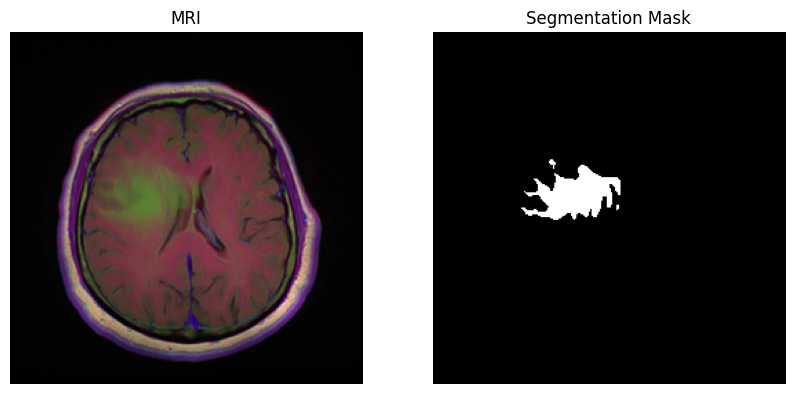

In [2]:
sanity_data = load_sanity_dataset()

X = sanity_data[0][0]
Y = sanity_data[0][1]
print('MRI shape', X.shape)
print('Mask shape',Y.shape)

plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.imshow(F.to_pil_image(X))
plt.title('MRI')
plt.axis('off')

plt.subplot(122)
plt.imshow(F.to_pil_image(Y), cmap='gray')
plt.title('Segmentation Mask')
plt.axis('off')

plt.show()

### SETR Model

In [3]:
# From https://github.com/gupta-abhay/setr-pytorch/tree/main

class FixedPositionalEncoding(nn.Module):
    def __init__(self, embedding_dim, max_length=5000):
        super(FixedPositionalEncoding, self).__init__()

        pe = torch.zeros(max_length, embedding_dim)
        position = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, embedding_dim, 2).float()
            * (-torch.log(torch.tensor(10000.0)) / embedding_dim)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[: x.size(0), :]
        return x


class LearnedPositionalEncoding(nn.Module):
    def __init__(self, max_position_embeddings, embedding_dim, seq_length):
        super(LearnedPositionalEncoding, self).__init__()
        self.pe = nn.Embedding(max_position_embeddings, embedding_dim)
        self.seq_length = seq_length

        self.register_buffer(
            "position_ids",
            torch.arange(max_position_embeddings).expand((1, -1)),
        )

    def forward(self, x, position_ids=None):
        if position_ids is None:
            position_ids = self.position_ids[:, : self.seq_length]

        position_embeddings = self.pe(position_ids)
        return x + position_embeddings
    
class IntermediateSequential(nn.Sequential):
    def __init__(self, *args, return_intermediate=True):
        super().__init__(*args)
        self.return_intermediate = return_intermediate

    def forward(self, input):
        if not self.return_intermediate:
            return super().forward(input)

        intermediate_outputs = {}
        output = input
        for name, module in self.named_children():
            output = intermediate_outputs[name] = module(output)

        return output, intermediate_outputs
    
class SelfAttention(nn.Module):
    def __init__(
        self, dim, heads=8, qkv_bias=False, qk_scale=None, dropout_rate=0.0
    ):
        super().__init__()
        self.num_heads = heads
        head_dim = dim // heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(dropout_rate)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(dropout_rate)

    def forward(self, x):
        B, N, C = x.shape
        qkv = (
            self.qkv(x)
            .reshape(B, N, 3, self.num_heads, C // self.num_heads)
            .permute(2, 0, 3, 1, 4)
        )
        q, k, v = (
            qkv[0],
            qkv[1],
            qkv[2],
        )  # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x):
        return self.fn(x) + x


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x):
        return self.fn(self.norm(x))


class PreNormDrop(nn.Module):
    def __init__(self, dim, dropout_rate, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fn = fn

    def forward(self, x):
        return self.dropout(self.fn(self.norm(x)))


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout_rate):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(p=dropout_rate),
        )

    def forward(self, x):
        return self.net(x)


class TransformerModel(nn.Module):
    def __init__(
        self,
        dim,
        depth,
        heads,
        mlp_dim,
        dropout_rate=0.1,
        attn_dropout_rate=0.1,
    ):
        super().__init__()
        layers = []
        for _ in range(depth):
            layers.extend(
                [
                    Residual(
                        PreNormDrop(
                            dim,
                            dropout_rate,
                            SelfAttention(
                                dim, heads=heads, dropout_rate=attn_dropout_rate
                            ),
                        )
                    ),
                    Residual(
                        PreNorm(dim, FeedForward(dim, mlp_dim, dropout_rate))
                    ),
                ]
            )
        self.net = IntermediateSequential(*layers)

    def forward(self, x):
        return self.net(x)


class SegmentationTransformer(nn.Module):
    def __init__(
        self,
        img_dim,
        patch_dim,
        num_channels,
        embedding_dim,
        num_heads,
        num_layers,
        hidden_dim,
        dropout_rate=0.0,
        attn_dropout_rate=0.0,
        conv_patch_representation=False,
        positional_encoding_type="learned",
    ):
        super(SegmentationTransformer, self).__init__()

        assert embedding_dim % num_heads == 0
        assert img_dim % patch_dim == 0

        self.img_dim = img_dim
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.patch_dim = patch_dim
        self.num_channels = num_channels
        self.dropout_rate = dropout_rate
        self.attn_dropout_rate = attn_dropout_rate
        self.conv_patch_representation = conv_patch_representation

        self.num_patches = int((img_dim // patch_dim) ** 2)
        self.seq_length = self.num_patches
        self.flatten_dim = patch_dim * patch_dim * num_channels

        self.linear_encoding = nn.Linear(self.flatten_dim, embedding_dim)
        if positional_encoding_type == "learned":
            self.position_encoding = LearnedPositionalEncoding(
                self.seq_length, self.embedding_dim, self.seq_length
            )
        elif positional_encoding_type == "fixed":
            self.position_encoding = FixedPositionalEncoding(
                self.embedding_dim,
            )

        self.pe_dropout = nn.Dropout(p=self.dropout_rate)

        self.transformer = TransformerModel(
            embedding_dim,
            num_layers,
            num_heads,
            hidden_dim,
            self.dropout_rate,
            self.attn_dropout_rate,
        )
        self.pre_head_ln = nn.LayerNorm(embedding_dim)

        if self.conv_patch_representation:
            self.conv_x = nn.Conv2d(
                self.num_channels,
                self.embedding_dim,
                kernel_size=(self.patch_dim, self.patch_dim),
                stride=(self.patch_dim, self.patch_dim),
                padding=self._get_padding(
                    'VALID', (self.patch_dim, self.patch_dim),
                ),
            )
        else:
            self.conv_x = None

    def _init_decode(self):
        raise NotImplementedError("Should be implemented in child class!!")

    def encode(self, x):
        n, c, h, w = x.shape
        if self.conv_patch_representation:
            # combine embedding w/ conv patch distribution
            x = self.conv_x(x)
            x = x.permute(0, 2, 3, 1).contiguous()
            x = x.view(x.size(0), -1, self.embedding_dim)
        else:
            x = (
                x.unfold(2, self.patch_dim, self.patch_dim)
                .unfold(3, self.patch_dim, self.patch_dim)
                .contiguous()
            )
            x = x.view(n, c, -1, self.patch_dim ** 2)
            x = x.permute(0, 2, 3, 1).contiguous()
            x = x.view(x.size(0), -1, self.flatten_dim)
            x = self.linear_encoding(x)

        x = self.position_encoding(x)
        x = self.pe_dropout(x)

        # apply transformer
        x, intmd_x = self.transformer(x)
        x = self.pre_head_ln(x)

        return x, intmd_x

    def decode(self, x):
        raise NotImplementedError("Should be implemented in child class!!")

    def forward(self, x, auxillary_output_layers=None):
        encoder_output, intmd_encoder_outputs = self.encode(x)
        decoder_output = self.decode(
            encoder_output, intmd_encoder_outputs, auxillary_output_layers
        )

        if auxillary_output_layers is not None:
            auxillary_outputs = {}
            for i in auxillary_output_layers:
                val = str(2 * i - 1)
                _key = 'Z' + str(i)
                auxillary_outputs[_key] = intmd_encoder_outputs[val]

            return decoder_output, auxillary_outputs

        return decoder_output

    def _get_padding(self, padding_type, kernel_size):
        assert padding_type in ['SAME', 'VALID']
        if padding_type == 'SAME':
            _list = [(k - 1) // 2 for k in kernel_size]
            return tuple(_list)
        return tuple(0 for _ in kernel_size)

    def _reshape_output(self, x):
        x = x.view(
            x.size(0),
            int(self.img_dim / self.patch_dim),
            int(self.img_dim / self.patch_dim),
            self.embedding_dim,
        )
        x = x.permute(0, 3, 1, 2).contiguous()
        return x


class SETR_Naive(SegmentationTransformer):
    def __init__(
        self,
        img_dim,
        patch_dim,
        num_channels,
        num_classes,
        embedding_dim,
        num_heads,
        num_layers,
        hidden_dim,
        dropout_rate=0.0,
        attn_dropout_rate=0.0,
        conv_patch_representation=False,
        positional_encoding_type="learned",
    ):
        super(SETR_Naive, self).__init__(
            img_dim=img_dim,
            patch_dim=patch_dim,
            num_channels=num_channels,
            embedding_dim=embedding_dim,
            num_heads=num_heads,
            num_layers=num_layers,
            hidden_dim=hidden_dim,
            dropout_rate=dropout_rate,
            attn_dropout_rate=attn_dropout_rate,
            conv_patch_representation=conv_patch_representation,
            positional_encoding_type=positional_encoding_type,
        )

        self.num_classes = num_classes
        self._init_decode()

    def _init_decode(self):
        self.conv1 = nn.Conv2d(
            in_channels=self.embedding_dim,
            out_channels=self.embedding_dim,
            kernel_size=1,
            stride=1,
            padding=self._get_padding('VALID', (1, 1),),
        )
        self.bn1 = nn.BatchNorm2d(self.embedding_dim)
        self.act1 = nn.ReLU()
        self.conv2 = nn.Conv2d(
            in_channels=self.embedding_dim,
            out_channels=self.num_classes,
            kernel_size=1,
            stride=1,
            padding=self._get_padding('VALID', (1, 1),),
        )
        self.upsample = nn.Upsample(
            scale_factor=self.patch_dim, mode='bilinear'
        )

    def decode(self, x, intmd_x, intmd_layers=None):
        x = self._reshape_output(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.conv2(x)
        x = self.upsample(x)
        x = torch.sigmoid(x) # JUSAN LISÄYS
        return x


### Sanity Test

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

torch.Size([3, 256, 256])
torch.Size([256, 256])
tensor(0.3432, grad_fn=<MinBackward1>) tensor(0.8030, grad_fn=<MaxBackward1>)


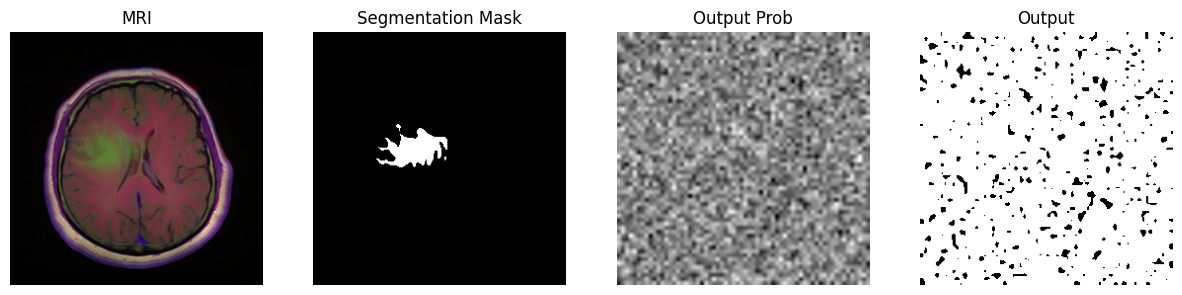

In [6]:
net = SETR_Naive(
    img_dim=256,
    patch_dim=4,
    num_channels=3,
    num_classes=1,
    embedding_dim=480,
    num_heads=12,
    num_layers=6,
    hidden_dim=64,
).to(device)


y_prob = net(X.unsqueeze(0)).to('cpu').squeeze()

print(X.shape)
print(y_prob.shape)
print(y_prob.min(), y_prob.max())

plt.figure(figsize=(15, 5))
plt.subplot(141)
plt.imshow(F.to_pil_image(X))
plt.title('MRI')
plt.axis('off')

plt.subplot(142)
plt.imshow(F.to_pil_image(Y), cmap='gray')
plt.title('Segmentation Mask')
plt.axis('off')

plt.subplot(143)
plt.imshow(F.to_pil_image(y_prob), cmap='gray')
plt.title('Output Prob')
plt.axis('off')

plt.subplot(144)
plt.imshow(F.to_pil_image(torch.round(y_prob)), cmap='gray')
plt.title('Output')
plt.axis('off')


plt.show()


In [7]:
def get_optimizer(net):
    return torch.optim.SGD(net.parameters(), lr=0.05, momentum=0.9)

def train(data_loader, net, optimizer, weight=(0.9, 0.1)):
    for data in data_loader:

        inputs, targets = data[0].to(device), data[1].to(device)
        outputs = net(inputs)

        loss = nn.BCELoss()(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        del inputs
        del targets

        return loss.item()

Epoch: 0 Loss: 0.8722777366638184
Epoch: 1 Loss: 0.19357815384864807
Epoch: 2 Loss: 0.11224604398012161
Epoch: 3 Loss: 0.14826121926307678
Epoch: 4 Loss: 0.1885027140378952
Epoch: 5 Loss: 0.22301489114761353
Epoch: 6 Loss: 0.2511860132217407
Epoch: 7 Loss: 0.27336445450782776
Epoch: 8 Loss: 0.29002678394317627
Epoch: 9 Loss: 0.3016696572303772
Epoch: 10 Loss: 0.3087848722934723
Epoch: 11 Loss: 0.3118637204170227
Epoch: 12 Loss: 0.3113856315612793
Epoch: 13 Loss: 0.30780792236328125
Epoch: 14 Loss: 0.30154818296432495
Epoch: 15 Loss: 0.2930049002170563
Epoch: 16 Loss: 0.28253400325775146
Epoch: 17 Loss: 0.27048900723457336
Epoch: 18 Loss: 0.2571946084499359
Epoch: 19 Loss: 0.24292469024658203
Epoch: 20 Loss: 0.22792860865592957
Epoch: 21 Loss: 0.2124350368976593
Epoch: 22 Loss: 0.19664698839187622
Epoch: 23 Loss: 0.18076761066913605
Epoch: 24 Loss: 0.16495436429977417
Epoch: 25 Loss: 0.149372398853302
Epoch: 26 Loss: 0.1341978907585144
Epoch: 27 Loss: 0.1195547878742218
Epoch: 28 Loss: 

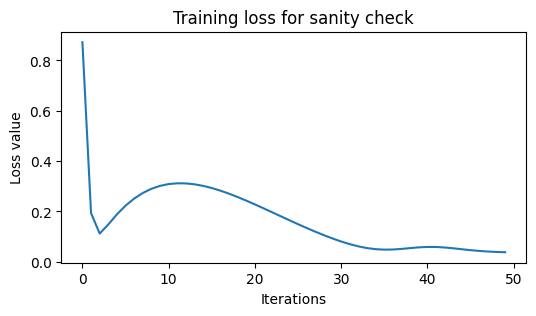

In [8]:
net.train()
optimizer = get_optimizer(net)
loss_graph = []

EPOCH = 50

sanity_loader = DataLoader(sanity_data, batch_size=1, num_workers=0, shuffle=False)
for e in range(EPOCH):
    loss = train(sanity_loader, net, optimizer)
    loss_graph.append(loss)
    print("Epoch: {} Loss: {}".format(e, loss))

plt.figure(figsize=(6, 3))
plt.plot(np.arange(0, EPOCH), loss_graph)
plt.xlabel('Iterations')
plt.ylabel('Loss value')
plt.title('Training loss for sanity check')
plt.show()

torch.Size([3, 256, 256])
torch.Size([256, 256])
tensor(6.9448e-10, grad_fn=<MinBackward1>) tensor(0.5850, grad_fn=<MaxBackward1>)


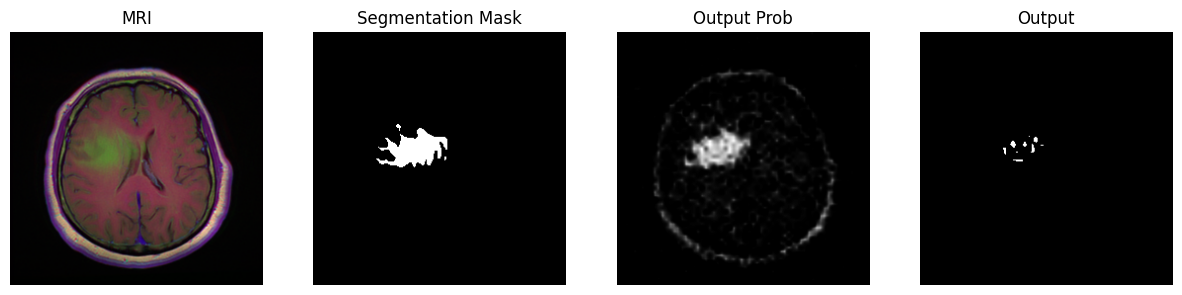

In [9]:
y_prob = net(X.unsqueeze(0)).to('cpu').squeeze()

print(X.shape)
print(y_prob.shape)
print(y_prob.min(), y_prob.max())

plt.figure(figsize=(15, 5))
plt.subplot(141)
plt.imshow(F.to_pil_image(X))
plt.title('MRI')
plt.axis('off')

plt.subplot(142)
plt.imshow(F.to_pil_image(Y), cmap='gray')
plt.title('Segmentation Mask')
plt.axis('off')

plt.subplot(143)
plt.imshow(F.to_pil_image(y_prob), cmap='gray')
plt.title('Output Prob')
plt.axis('off')

plt.subplot(144)
plt.imshow(F.to_pil_image(torch.round(y_prob)), cmap='gray')
plt.title('Output')
plt.axis('off')

plt.show()